# Насколько плох переезд 

В хорошем подмосковном городе есть плохой железнодорожный переезд. В час пик встает не только он, но и соседние перекрестки и дороги. Проезжая в очередной раз, я задался вопросом - какая у него пропускная способность и можно ли что-то изменить?

![Переезд](img/railroad.jpg)

Для ответа мы немного углубимся в нормативы и теорию транспортных потоков, проанализируем данные GPS и акселерометра с помощью Python и сравним теоретические расчеты с экспериментальными данными.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исходные-данные" data-toc-modified-id="Исходные-данные-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исходные данные</a></span></li><li><span><a href="#Теория-транспортного-потока" data-toc-modified-id="Теория-транспортного-потока-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Теория транспортного потока</a></span></li><li><span><a href="#Сбор-и-анализ-данных" data-toc-modified-id="Сбор-и-анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Сбор и анализ данных</a></span><ul class="toc-item"><li><span><a href="#Ручной-подсчет-интенсивности-движения" data-toc-modified-id="Ручной-подсчет-интенсивности-движения-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Ручной подсчет интенсивности движения</a></span></li><li><span><a href="#Измерение-средней-скорости-на-переезде" data-toc-modified-id="Измерение-средней-скорости-на-переезде-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Измерение средней скорости на переезде</a></span><ul class="toc-item"><li><span><a href="#Визуализация-на-карте" data-toc-modified-id="Визуализация-на-карте-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Визуализация на карте</a></span></li><li><span><a href="#Визуализация-профиля-переезда" data-toc-modified-id="Визуализация-профиля-переезда-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Визуализация профиля переезда</a></span></li></ul></li><li><span><a href="#Оценка-плотности" data-toc-modified-id="Оценка-плотности-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Оценка плотности</a></span></li></ul></li><li><span><a href="#Итоги" data-toc-modified-id="Итоги-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Итоги</a></span></li></ul></div>

## Исходные данные

Мы имеет одноколейный железнодорожный переезд с плохим качеством дороги, скорость на котором примерно 10 км/ч. Из подручных средств современный смартфон и ноутбук. 

Весь код и данные доступны в формате Jupyter Notebook на моем [GitHub'е](https://github.com/Ushakovvk/railroad-crossing).

![Переезд](img/railroad_real.jpg)

Нам понадобятся следующие библиотеки:

In [1]:
import pandas as pd
import numpy as np
import glob

#!pip install utm
import utm

from sklearn.decomposition import PCA
from scipy import interpolate

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 8)})
import plotly.express as px

# Токен Mapbox для карт в Plotly
mapbox_token = open('mapbox_token', 'r').read()

## Теория транспортного потока

Для начала определимся с терминами.

**Плотность движения** $\rho$ - Число автомобилей на 1 км дороги.


$v$ - **скорость АТС**.


**Интенсивность движения** $Q(\rho)$ - Количество транспортных средств, проходящие в единицу времени через определенное сечение дороги.

**Пропускная способность** $P$ - Максимальное число автомобилей, которое может пропустить участок дороги в единицу времени в одном или двух направлениях в рассматриваемых дорожных и погодно-климатических условиях.

Плотность движения и интенсивность связаны формулой:
$$Q = V \cdot \rho$$



Зависимость $Q(\rho)$ часто называют **фундаментальной диаграммой**. 


Так на графике ниже отображены экспериментальные данные «Центра исследования транспортной инфраструктуры» г. Москвы, собранные в течение одного дня в 2005 г. по четырем полосам на участке третьего транспортного кольца от Автозаводской улицы до Варшавского шоссе, и сагрегированные на одну полосу.

![Фундаментальная диаграмма](img/Q(rho).png)

**Оценка пропускной способности**

Основным документом при оценке пропускной способности дорог и их элементов является документ [ОДМ 218.2.020-2012](http://docs.cntd.ru/document/1200092512) "Методические рекомендации по оценке пропускной способности автомобильных дорог".

Для железнодорожных переездов выделен целый раздел, и пропускная способность в разных дорожных условиях рассчитывается по формуле:

$$P_{ж.п.}=P_д \cdot \beta^{ж.п.}_1 \cdot \beta^{ж.п.}_2 \cdot \beta^{ж.п.}_3 \cdot \beta^{ж.п.}_4 \cdot \beta^{ж.п.}_5,$$

где $\beta^{ж.п.}_1,\beta^{ж.п.}_2,\beta^{ж.п.}_3,\beta^{ж.п.}_4,\beta^{ж.п.}_5$ - коэффициенты снижения пропускной способности, учитывающие состав движения, характеристики железнодорожных переездов и дорожные условия в зоне переезда, которые определяются по приведенным таблицам.

Рассчитаем пропускную способность, исходя из наших условий:

$$P_{ж.п.}=1500 \cdot 0.93 \cdot 0.66 \cdot 0.8 \cdot 1 \cdot 1 = 736.56 авт./ч = 12.3 авт./мин$$

Мы получили теоретическую оценку, теперь перейдем к тому, что есть на самом деле.

В реальных условиях я использовал 2 метода оценки пропускной способности:

- Непосредственный подсчет проехавших через переезд АТС;
- Вычисление средней скорости движения АТС в выделенной нами области и применение различных функционалов для определения плотности.


В качестве функционала можно использовать простые модели:

- Модель Танака:

$\rho(v)=\frac{1}{d(v)}$,

$d(v)= L+ c_1 v+ c_2 v^2$,

где $d(v)$ – среднее (безопасное) расстояние между АТС, $L$ – средняя длина АТС, $c_1$ – время, характеризующее реакцию водителя, $c_2$ - коэффициент пропорциональности тормозному пути. При нормальных условиях (сухой асфальт): $L$=5.7 $м$, $c_1$=0.504 $c$, $c_2$=0.0285 $с^2/м$.

- Модель Гриндшилдса:

$\rho= \rho_{max} (1 - \frac{v}{v_{max}})$,

где $\rho_{max}$ - максимальная плотность потока (при отсутствии движения), $v_{max}$ - максимальная (желаемая) скорость движения АТС (при пустой дороге). Эти данные можно взять из того же ОДМ 218.2.020-2012 - $\rho_{max} = 85 авт./км, v_{max}=60 км/ч$

In [2]:
# Загрузка данных для Диаграммы уравнения потока
diagram1 = pd.read_csv('Диаграмма уравнения потока.csv', sep=';', header=None, names=['P', 'V'], decimal=',')
diagram1_func = interpolate.interp1d(diagram1['P'], diagram1['V'], kind='cubic')
diagram1_xnew = np.arange(diagram1['P'].min(), diagram1['P'].max())

# Загрузка данных для Фундаментальной диаграммы
diagram2 = pd.read_csv('Фундаментальная диаграмма.csv', sep=';', header=None, names=['P', 'Q'], decimal=',')
diagram2_func = interpolate.interp1d(diagram2['P'], diagram2['Q'], kind='cubic')
diagram2_xnew = np.arange(diagram2['P'].min(), diagram2['P'].max())

In [3]:
def density_Tanaka(V):
    # Функция плотности для модели Танака
    
    V = V * 1000 / 60 / 60 # переводим км/ч в м/с
    L = 5.7 # м
    c1 = 0.504 # с
    c2 = 0.0285 #с**2/м
    
    return 1000 / (L + c1 * V + c2 * V**2) # авт./км

def density_Grindshilds(V):
    # Функция плотности для модели Гриндшилдса 
    
    pmax = 85 # авт./км
    vmax = 60 # км/ч
    
    return pmax * (1 - V / vmax) # авт./км

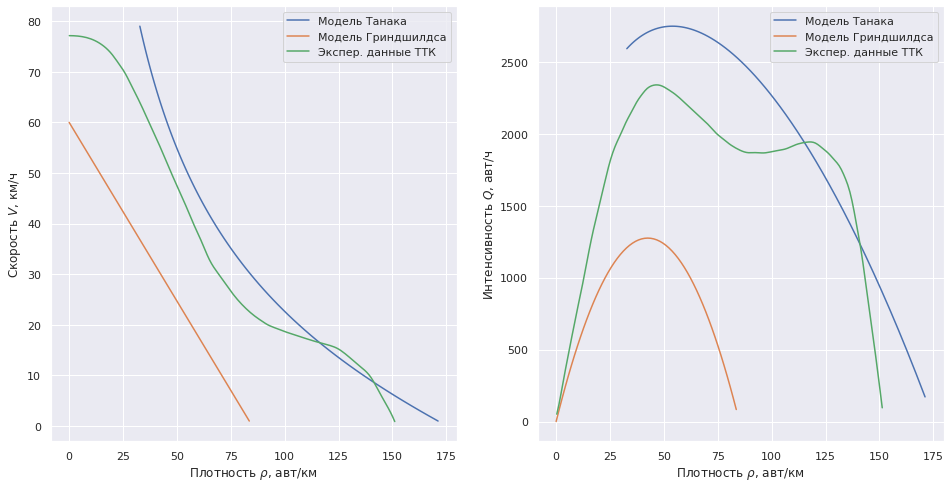

In [4]:
# Построение графиков
V = np.arange(1, 80) # км/ч
V1 = np.arange(1, 61) # км/ч

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.plot(density_Tanaka(V), V, label="Модель Танака")
ax1.plot(density_Grindshilds(V1), V1, label="Модель Гриндшилдса")
ax1.plot(diagram1_xnew, diagram1_func(diagram1_xnew), label="Экспер. данные ТТК")
ax1.set_xlabel(r'Плотность $\rho$, авт/км')
ax1.set_ylabel(r'Скорость $V$, км/ч')
ax1.legend()

ax2.plot(density_Tanaka(V), density_Tanaka(V) * V, label="Модель Танака")
ax2.plot(density_Grindshilds(V1), density_Grindshilds(V1) * V1, label="Модель Гриндшилдса")
ax2.plot(diagram2_xnew, diagram2_func(diagram2_xnew), label="Экспер. данные ТТК")
ax2.set_xlabel(r'Плотность $\rho$, авт/км')
ax2.set_ylabel(r'Интенсивность $Q$, авт/ч')
ax2.legend()

plt.show()

Модель Гриндшилдса с исходными данными для переезда существенно занижает интенсивность по сравнению с экспериментальными данными для обычной дороги. Давайте сравним эту модель с реальностью.

## Сбор и анализ данных

### Ручной подсчет интенсивности движения

Я не стал усложнять и применять нейронные сети для распознавания машин, а просто написал кейлогер с сохранением времени и нажатой клавиши. Чтобы после каждого нажатия не вводить Enter, код немного усложнился:

In [ ]:
%%writefile "key-logger.py"
import pandas as pd
import time
import datetime


class _GetchUnix:
    # from https://code.activestate.com/recipes/134892/
    def __init__(self):
        import tty, sys

    def __call__(self):
        import sys, tty, termios
        fd = sys.stdin.fileno()
        old_settings = termios.tcgetattr(fd)
        try:
            tty.setraw(sys.stdin.fileno())
            ch = sys.stdin.read(1)
        finally:
            termios.tcsetattr(fd, termios.TCSADRAIN, old_settings)
        return ch


def logging():
    path = 'logs/keylog/'
    filename = f"{time.strftime('%Y-%m-%d %H-%M-%S')}.csv"
    path_to_file = path + filename
    db = []
    getch = _GetchUnix()
    print('Процесс...')
    while True:
        key = getch()
        if key == 'c':
            break
        else:
            db.append((datetime.datetime.now(), key))
    df = pd.DataFrame(db, columns=['time', 'click'])
    print(df)
    df.to_csv(path_to_file, index=False)
    print(f"\nSaved to {filename}")

if __name__ == "__main__":
    logging()

Пришлось посидеть возле переезда 20 минут и внимательно смотреть за потоком. Я записал 2 периода сразу после проезда поезда, т. е. при загрузке переезда на 100%:

In [5]:
files = glob.glob('logs/keylog/*.csv')
keylogger_data = []
print(f'Количество файлов - {len(files)} шт.')
for filename in files:
    df = pd.read_csv(filename, parse_dates=['time'])
    keylogger_data.append(df)
keylogger_data = pd.concat(keylogger_data, ignore_index=True)
keylogger_data.head()

Количество файлов - 2 шт.


,time,click
0,2020-09-29 16:24:02.691189,d
1,2020-09-29 16:24:05.186670,a
2,2020-09-29 16:24:07.157702,d
3,2020-09-29 16:24:11.506961,a
4,2020-09-29 16:24:14.206266,a


Клавиша "a" - машина проехала через переезд из города, клавиша 'd' - в город.

Сагрегируем данные по минутам и направлению:

In [6]:
keylogger_data['time'] = keylogger_data['time'].astype('datetime64[m]')
keylogger_per_min = keylogger_data.groupby(['click', 'time'], as_index=False).size().reset_index().rename(columns={0:'size'})
keylogger_per_min.head()

,index,click,time,size
0,0,a,2020-09-29 16:24:00,12
1,1,a,2020-09-29 16:25:00,13
2,2,a,2020-09-29 16:26:00,9
3,3,a,2020-09-29 16:27:00,18
4,4,a,2020-09-29 16:28:00,14


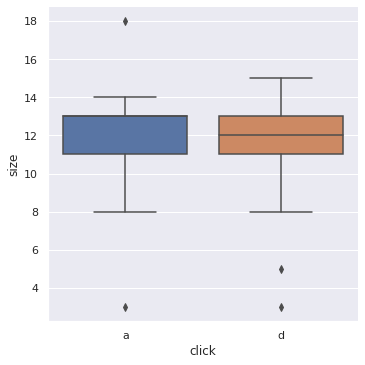

In [7]:
sns.catplot(x='click', y='size', kind="box", data=keylogger_per_min);

In [8]:
print(f"Средняя пропускная способность: {keylogger_per_min['size'].mean():.1f} авт./мин \
или {keylogger_per_min['size'].mean() * 60:.1f} авт./ч")

Средняя пропускная способность: 11.7 авт./мин или 700.0 авт./ч


Экспериментальная интенсивность почти соответствуют расчетной с неудовлетворительным состоянием переезда.

Вспомним нашу модель Гриншильдса - интенсивности в 700 авт./ч соответствует скорость около 10 км/ч (о 50 км/ч речи не идет) - по ощущения при переезде это так и есть.

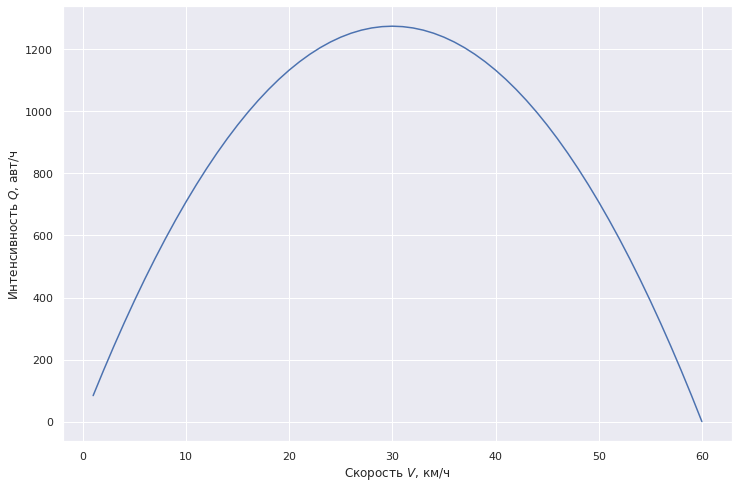

In [9]:
plt.plot(V1, density_Grindshilds(V1)*V1, label="Модель Гриндшилдса")
plt.xlabel(r'Скорость $V$, км/ч')
plt.ylabel(r'Интенсивность $Q$, авт/ч')
plt.show()

### Измерение средней скорости на переезде

Для измерения скорости я использовал приложение для Android **GPSLogger** с сохранением трекинга в csv файлы. В процессе написания статьи возникла идея посмотреть на данные акселерометра (линейного ускорения) с привязкой данных GPS - с этим отлично справилось приложение **Physics Toolbox Suite**.

За всё время у меня набралось около 50 проходов переезда. Данные записывались и при нулевом трафике и в пробках - я старался проезжать переезд со скоростью потока.

Загрузим все данные, при этом сразу добавим информацию о направлении движения - это понадобится в дальнейшем для графиков.

**Данные приложения GPSLogger**

Приложение GPSLogger сохраняет много информации, но нам потребуется только:

- time - дата и время;
- lat и lon - широта и долгота, $град$;
- speed - скорость, $м/с^2$;
- direction - направление, в город или из города.

In [10]:
files = glob.glob('logs/gps/*.csv')
gpslogger_data = []
print(f'Количество файлов с данными GPS - {len(files)} шт.')
for filename in files:
    df = pd.read_csv(filename, parse_dates=['time'], index_col='time')
    if df.iloc[10, 1] < df.iloc[-1, 1]:
        df['direction'] = 0 # в город
    else:
        df['direction'] = 1 # из города
    gpslogger_data.append(df)
gpslogger_data = pd.concat(gpslogger_data)
gpslogger_data.head()

gps_1 = gpslogger_data[['lat', 'lon', 'speed', 'direction']]

Количество файлов с данными GPS - 37 шт.


**Данные приложения Physics Toolbox Suite:**

In [11]:
files = glob.glob('logs/gps_accel/*.csv')
print(f'Количество файлов с данными акселерометра - {len(files)} шт.')
pts_data = []

for filename in files:
    df = pd.read_csv(filename, sep=';',decimal=',')
    df['time'] = filename[-22:-12] + '-' + df['time']
    if df.iloc[10, 5] < df.iloc[-1, 5]:
        df['direction'] = 0 # в город
    else:
        df['direction'] = 1 # из города
    pts_data.append(df)
pts_data = pd.concat(pts_data)
pts_data.head()

Количество файлов с данными акселерометра - 14 шт.


,time,ax,ay,az,Latitude,Longitude,Speed (m/s),Unnamed: 7,direction
0,2020-09-04-14:11:18:029,0.0,0.0,0.0,0.000000,0.00000,0.0,NaN,1
1,2020-09-04-14:11:18:030,0.0,0.0,0.0,56.372343,37.53044,0.0,NaN,1
2,2020-09-04-14:11:18:030,0.0,0.0,0.0,56.372343,37.53044,0.0,NaN,1
3,2020-09-04-14:11:18:094,0.0,0.0,0.0,56.372343,37.53044,0.0,NaN,1
4,2020-09-04-14:11:18:094,0.0,0.0,0.0,56.372343,37.53044,0.0,NaN,1


Данные содержат некорректные записи с нулевой широтой, долготой - почистим:

In [12]:
pts_data = pts_data.query('Latitude != 0.')

Приложение Physics Toolbox Suite записывает данные с максимальной частотой для акселерометра 400 Гц, но датчик GPS работает с частотой 1 Гц, поэтому разделим данные по датчикам:

In [13]:
pts_data['time'] = pd.to_datetime(pts_data['time'], format='%Y-%m-%d-%H:%M:%S:%f')
pts_data = pts_data.rename(columns={'Latitude':'lat', 'Longitude':'lon', 'Speed (m/s)':'speed'})

Данные акселерометра:

In [14]:
accel_data = pts_data[['time', 'lat', 'lon', 'ax', 'ay', 'az', 'direction']].copy()
accel_data = accel_data.set_index('time')
accel_data['direction'] = accel_data['direction'].map({1.: 'Из города', 0.: 'В город'})
accel_data.head()

,lat,lon,ax,ay,az,direction
time,,,,,,
2020-09-04 14:11:18.030,56.372343,37.53044,0.0,0.0,0.0,Из города
2020-09-04 14:11:18.030,56.372343,37.53044,0.0,0.0,0.0,Из города
2020-09-04 14:11:18.094,56.372343,37.53044,0.0,0.0,0.0,Из города
2020-09-04 14:11:18.094,56.372343,37.53044,0.0,0.0,0.0,Из города
2020-09-04 14:11:18.095,56.372343,37.53044,0.0,0.0,-0.0,Из города


Данные GPS:

In [15]:
gps_2 = pts_data[['time', 'lat', 'lon', 'speed', 'direction']].copy()
gps_2 = gps_2.set_index('time')
gps_2 = gps_2.resample('S').mean()
gps_2 = gps_2.dropna(how='all')
gps_2.head()

,lat,lon,speed,direction
time,,,,
2020-08-10 00:45:02,56.338342,37.522946,0.0,1.0
2020-08-10 00:45:03,56.338342,37.522946,0.0,1.0
2020-08-10 00:45:04,56.338342,37.522946,0.0,1.0
2020-08-10 00:45:05,56.338342,37.522946,0.0,1.0
2020-08-10 00:45:06,56.338342,37.522946,0.0,1.0


Объединим все GPS данные:

In [16]:
gps_data = gps_1.append(gps_2, ignore_index=True)
gps_data['direction'] = gps_data['direction'].map({1.: 'Из города', 0.: 'В город'})
gps_data.head()

,lat,lon,speed,direction
0,56.167241,37.504026,19.82,Из города
1,56.167051,37.503804,19.36,Из города
2,56.166884,37.503667,19.62,Из города
3,56.166718,37.503554,19.35,Из города
4,56.166570,37.503427,19.12,Из города


#### Визуализация на карте

Визуализируем данные на карте с помощью библиотеки Plotly:

In [ ]:
fig = px.scatter_mapbox(gps_data, lat="lat", lon="lon", color='direction', zoom=17, height=600)
fig.update_layout(mapbox_accesstoken=mapbox_token, mapbox_style='streets')
fig.show()

#### Визуализация профиля переезда

Чтобы построить график продольного сечения переезда нужно выполнить два преобразования:

1. Перевести координаты GPS, а это обычно система координат WGS 84 в плоскую проекцию. 
2. Спроецировать данные на профиль дороги.

В сервисах онлайн карт обычно используется проекция Web Mercator, которая имеет один недостаток - это сильное искажение расстояний, именно поэтому Гренландия на картах выглядит больше Африки, хотя на самом деле меньше в несколько раз.

Для геодезических и картографических работ применяются проекции, основанные на поперечной проекции Меркатора. В России и многих других странах применяется проекция Гаусса — Крюгера, в США — универсальная поперечная проекция Меркатора (UTM).

Проекция Web-Mercator
![Проекция Web-Mercator](img/Web_Mercator.png)

Проекция UTM
![Проекция UTM](img/utm_zones.png)

Для преобразования в UTM для Python есть простое решение https://github.com/Turbo87/utm, его и будем использовать.

In [17]:
gps_data['xs'] = gps_data[['lat', 'lon']].apply(lambda x: utm.from_latlon(x[0], x[1])[0], axis=1)
gps_data['ys'] = gps_data[['lat', 'lon']].apply(lambda x: utm.from_latlon(x[0], x[1])[1], axis=1)
gps_data['speed_kmh'] = gps_data.speed / 1000 * 60 * 60

Оставим данные только вокруг переезда в радиусе 50 метров:

In [18]:
# Координаты переезда
lat0 = 56.35205
lon0 = 37.51792
xc, yc, _, _ = utm.from_latlon(lat0, lon0)

r = 50
gps_data = gps_data.query(f'{xc - r} < xs & xs < {xc + r}')\
                   .query(f'{yc - r} < ys & ys < {yc + r}')

In [ ]:
fig = px.scatter_mapbox(gps_data, lat="lat", lon="lon", color='direction', zoom=17, height=600)
fig.update_layout(mapbox_accesstoken=mapbox_token, mapbox_style='streets')
fig.show()

Теперь спроецируем точки на ось дороги. Это по сути задача понижения размерности с 2d в 1d, которая решается методом главных компонент (PCA). 

Мы можем поступить 2 способами — вручную вычислить матрицу поворота и взять одну компоненту или довериться реализации scikit-learn. Для простоты выберем Sklearn:

In [19]:
pca = PCA(n_components=1).fit(gps_data[['xs', 'ys']])
gps_data['xs_transform'] = pca.transform(gps_data[['xs', 'ys']])

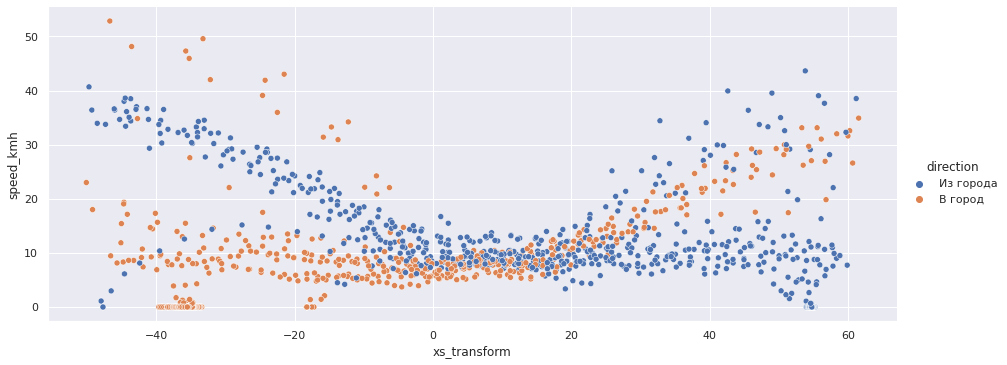

In [20]:
sns.relplot(x='xs_transform', y='speed_kmh', data=gps_data, aspect=2.5, hue='direction');

В большинстве случаев после переезда скорость возрастает. По графику можно выделить границы переезда - это примерно интервал [-5, 25]. Для уточнения посмотрим на данные с акселерометра.

In [21]:
accel_data['xs'] = accel_data[['lat', 'lon']].apply(lambda x: utm.from_latlon(x[0], x[1])[0], axis=1)
accel_data['ys'] = accel_data[['lat', 'lon']].apply(lambda x: utm.from_latlon(x[0], x[1])[1], axis=1)
accel_data = accel_data.query(f'{xc - r} < xs & xs < {xc + r}')\
                       .query(f'{yc - r} < ys & ys < {yc + r}')
accel_data['xs_transform'] = pca.transform(accel_data[['xs', 'ys']])

Оси акселерометра в Android располагаются следующим образом:
![Оси акселерометра](img/accel.png)

При записи данных телефон всегда лежал по ходу движения (ось Y). Посмотрим на графики отдельно по осям:

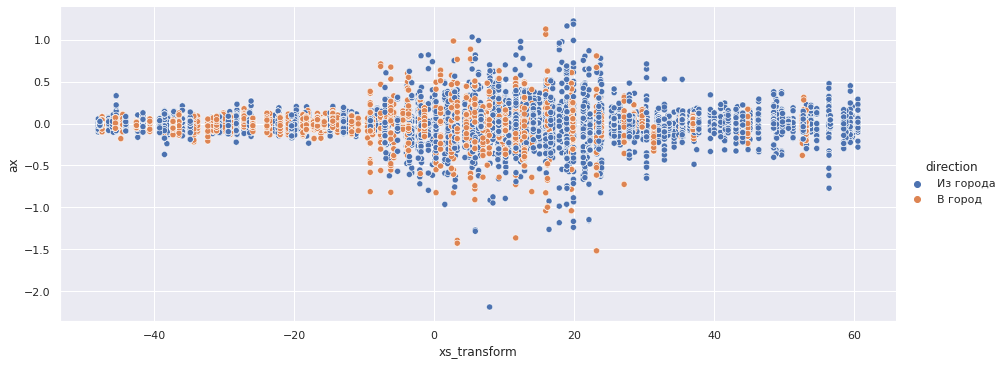

In [22]:
sns.relplot(x='xs_transform', y='ax', data=accel_data, aspect=2.5, hue='direction');

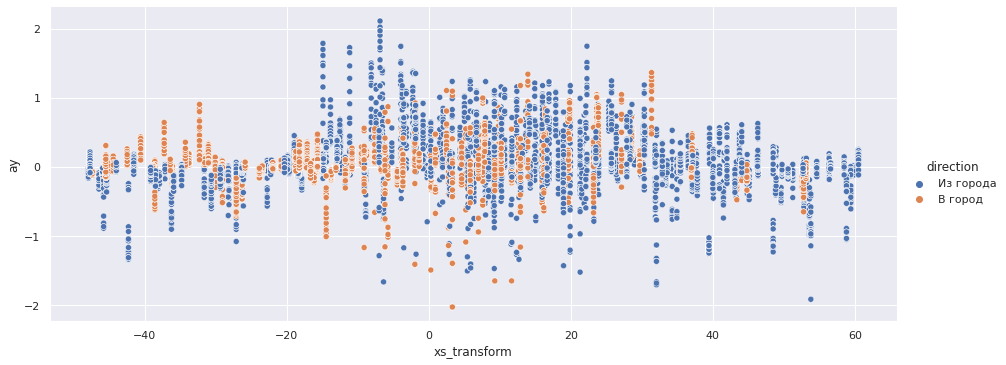

In [23]:
sns.relplot(x='xs_transform', y='ay', data=accel_data, aspect=2.5, hue='direction');

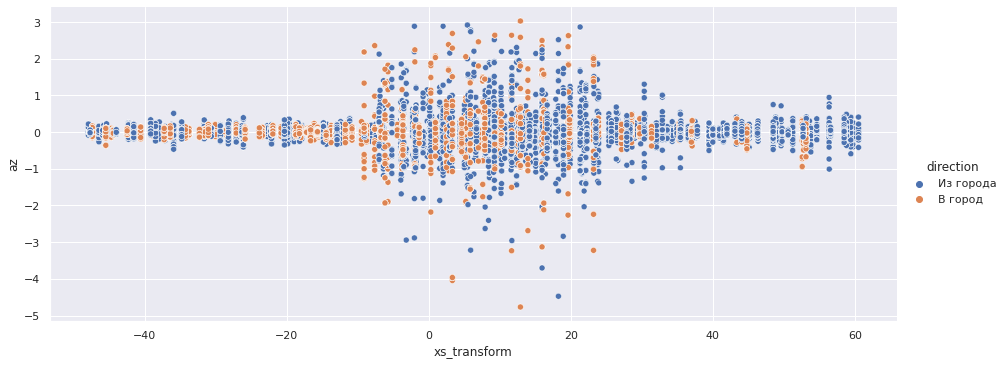

In [24]:
sns.relplot(x='xs_transform', y='az', data=accel_data, aspect=2.5, hue='direction');

Увеличим масштаб по оси Z:

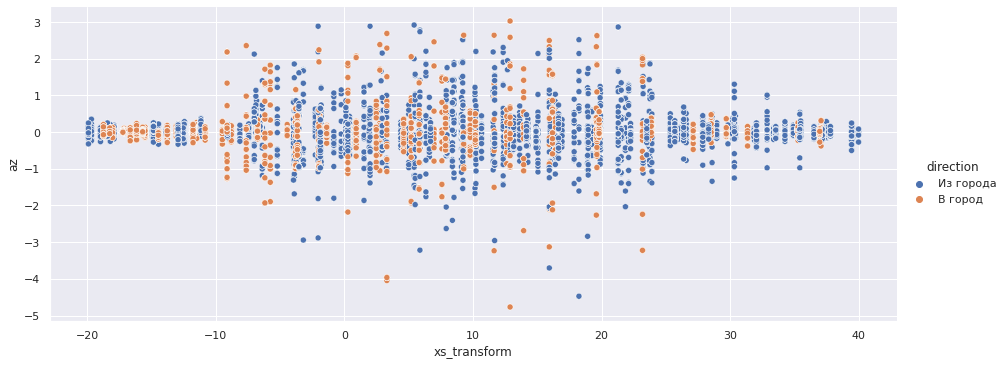

In [25]:
sns.relplot(x='xs_transform', y='az', data=accel_data.query('-20 < xs_transform < 40'), aspect=2.5, hue='direction');

По осям X и Z четко определяются границы переезда - интервал [-10, 25] с центром в точке 7.5.

In [26]:
cross = gps_data.query('-10 < xs_transform < 25')

In [ ]:
fig = px.scatter_mapbox(cross, lat="lat", lon="lon", color='direction', zoom=19, height=600)
fig.update_layout(mapbox_accesstoken=mapbox_token, mapbox_style='streets')
fig.show()

Теперь посмотрим как распределена скорость на переезде:

Средняя скорость на переезде - 9.4 км/ч


/home/vadim/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


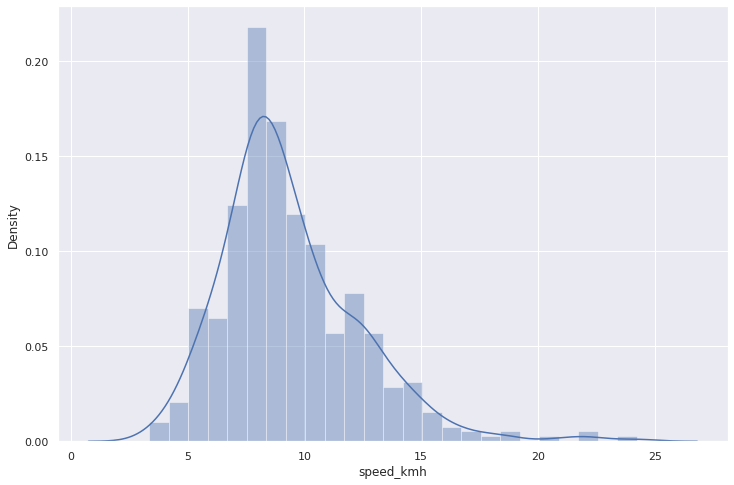

In [27]:
mean_v = cross.speed_kmh.mean()
print(f"Средняя скорость на переезде - {mean_v:.2} км/ч")
sns.distplot(cross.speed_kmh);

Округлим координаты до метра и построим еще немного красивых графиков:

In [28]:
base = 1
gps_data['xs_transform_round'] = gps_data['xs_transform'].apply(lambda x: base * round(x / base))
accel_data['xs_transform_round'] = accel_data['xs_transform'].apply(lambda x: base * round(x / base))

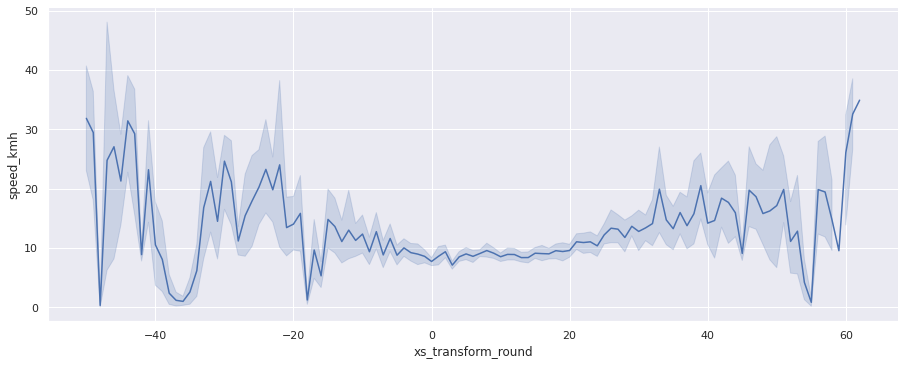

In [29]:
sns.relplot(x='xs_transform_round', y='speed_kmh', data=gps_data, kind="line", aspect=2.5);

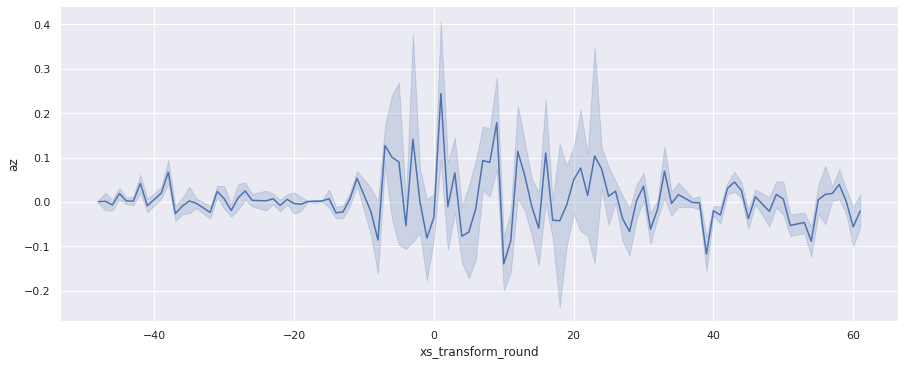

In [30]:
sns.relplot(x='xs_transform_round', y='az', data=accel_data, kind="line", aspect=2.5);

### Оценка плотности

Для расчета пропускной способности используем две модели для плотности:

In [31]:
gps_data['flow_Tanaka'] = density_Tanaka(gps_data.speed_kmh) * gps_data.speed_kmh
gps_data['flow_Grindshilds'] = density_Grindshilds(gps_data.speed_kmh) * gps_data.speed_kmh

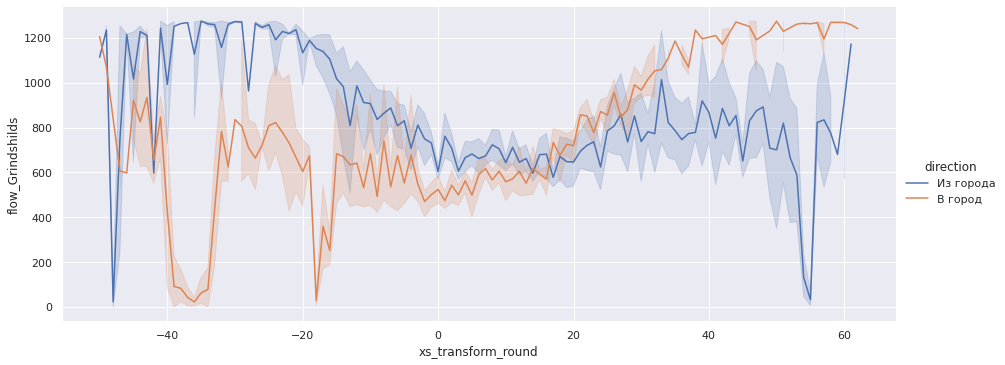

In [32]:
sns.relplot(x='xs_transform_round', y='flow_Grindshilds', data=gps_data, aspect=2.5, kind='line', hue='direction');

In [33]:
cross = gps_data.query('-10 < xs_transform < 25')

In [34]:
mean_flow_Tanaka = cross.flow_Tanaka.mean()
print(f"Средняя пропускная способность по модели Танака - {mean_flow_Tanaka:.1f} авт/ч \
или {mean_flow_Tanaka / 60:.1f} авт/мин")

Средняя пропускная способность по модели Танака - 1275.5 авт/ч или 21.3 авт/мин


In [35]:
mean_flow_Grindshilds = cross.flow_Grindshilds.mean()
print(f"Средняя пропускная способность по модели Гриншильдса - {mean_flow_Grindshilds:.1f} авт/ч \
или {mean_flow_Grindshilds / 60:.1f} авт/мин")

Средняя пропускная способность по модели Гриншильдса - 660.0 авт/ч или 11.0 авт/мин


Как видно, наша оценка по модели Гриншильдса наиболее близка данным эксперимента в 700 авт./ч.

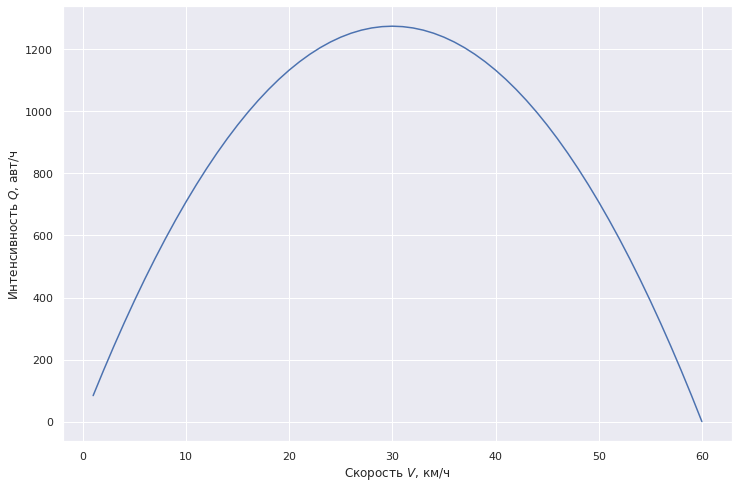

In [36]:
plt.plot(V1, density_Grindshilds(V1)*V1, label="Модель Гриндшилдса")
plt.xlabel(r'Скорость $V$, км/ч')
plt.ylabel(r'Интенсивность $Q$, авт/ч')
plt.show()

Исходя из этой модели, если мы каким-то образом увеличим скорость на переезде всего до 30 км/ч - пропускная способность увеличится почти в два раза.
Примерно тоже самое мы получим при расчете по формуле, введя коэффициент для хорошей ровности дороги:

$$P_{ж.п.}=1500 \cdot 0.93 \cdot 0.98 \cdot 0.8 \cdot 1 \cdot 1 = 1093.7 авт./ч = 18.3 авт./мин$$

Также проблему железнодорожных переездов с предложениями хорошо осветил автор статьи ["Как надо решать проблему ж/д переездов"](https://crusandr.livejournal.com/127814.html).

## Итоги

Исходя из нашего анализа можно утверждать, что железнодорожный переезд находится в неудовлетворительном состоянии и скорость потока составляется примерно 10 км/ч, что при полной загрузке дороги вызывает затруднение движения и пробки. 

Пропускную способность переезда можно существенно повысить при приведение переезда в удовлетворительное состояние.